In [1]:
import numpy as np
import cvxpy as cvx
import gurobipy as grb
import scipy.sparse
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 1

Inequality-constrained LP in 2 dimensions:

$$
\min_{x \in \mathbb{R}^2} p^Tx \\
\text{s.t.} \quad Ax \le b
$$

Feasible set is a compact polygon that lies within $[-1, 1] \times [-1, 1]$.

I will solve the problem by barrier method: minimize $f_t(x) = t p^Tx - \sum \log(-A_ix + b_i)$ on each iteration, where $A_i$ is a $i^{th}$ row of A.

For Newton method method we need Gradient and Hessian:

$$
\nabla f_t = tp - \sum_{i=1}^M \frac{A_i^T}{A_ix - b_i} \\
\Delta^2 f_t = \sum_{i=1}^M \frac{1}{\left( A_ix - b_i \right)^2}\begin{pmatrix} A_{i1}A_{i1} & A_{i1}A_{i2} \\ A_{i1}A_{i2} & A_{i2}A_{i2} \end{pmatrix}
$$

In [2]:
def barrier(p, b, A, x0, mu, lmbda, t, x_steps):
    """Interior-point method for an inequality-constrained LP in 2 dimensions.

    Args:
        p: objective - vector of size 2.
        b: right side of inequality constraint - vector of size 2.
        A: matrix in left side of inequality canstraint - size 2*2.
        x0: strictly feasible point.
        mu: coefficient to increase t.
        lmbda: lambda (dual variable).
        t: coefficient in Newton method.
        x_steps: Array of solutions on each iteration.
    Returns:
        Returns point - solution to the problem 

    """
    def f(x):
        if np.any(-A.dot(x) + b <= 0):
            return np.inf
        else:
            return t * p.dot(x) - np.sum(np.log(-A.dot(x) + b))
    
    def find_lmbda(fun, alpha=1.):
        while fun(alpha) == np.inf:
            alpha /= 2
        return alpha
    x = x0
    while A.shape[0] / t >= eps:
        hessian = np.eye(2) * 0
        grad = t*p - np.sum(A.T / np.atleast_2d((A.dot(x) - b)), axis=1)
        for i in range(A.shape[0]):
            hessian = hessian + 1. / (A[i, :].dot(x) - b[i])**2 *\
            np.array([[A[i, 0] * A[i, 0], A[i, 0] * A[i, 1]], [A[i, 0] * A[i, 1], A[i, 1] * A[i, 1]]])
        lmbda = find_lmbda(lambda alpha: f(x - alpha * np.linalg.lstsq(hessian, grad)[0]))
        x = x - lmbda * np.linalg.lstsq(hessian, grad)[0]
        x_steps.append(x)
        t = mu * t
    return x

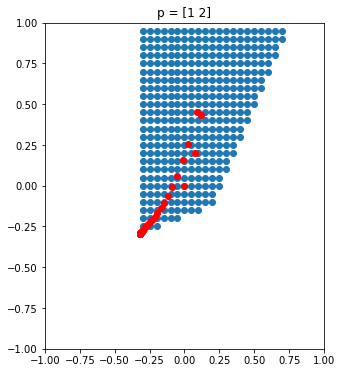

Solution point is: [-0.32108781 -0.29626668]


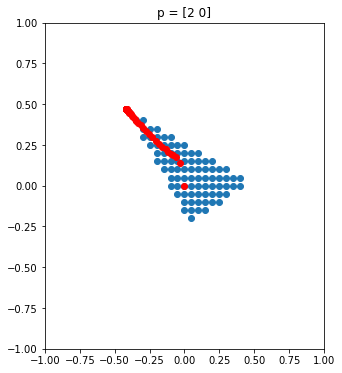

Solution point is: [-0.4186889   0.47150757]


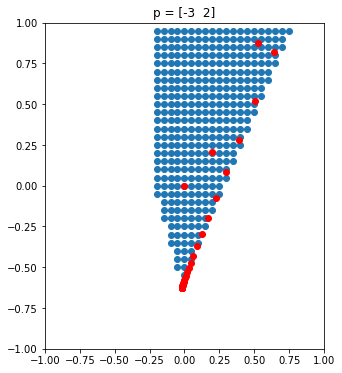

Solution point is: [-0.01904837 -0.62477067]


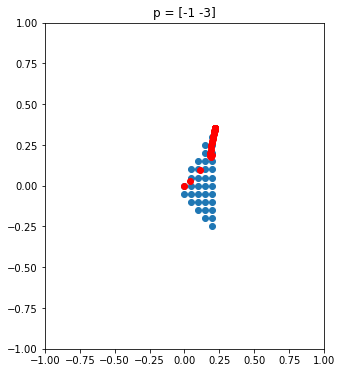

Solution point is: [ 0.22036466  0.35620676]


In [3]:
x0 = np.array([0, 0])
mu = 1.2
t = 1
lmbda = 0.2
eps = 1e-3
n = 5

for i in range(4):
    np.random.seed(i) 
    p = np.random.randint(-3, 3, 2)
    A = np.random.randint(-3, 3, (n,2))
    b = np.random.rand(n)
    
    x_steps = [x0]
    
    x = barrier(p, b, A, x0, mu, lmbda, t, x_steps)
    
    x1, x2 = np.mgrid[-1:1:0.05, -1:1:0.05]
    
    x1 = x1.reshape(-1)
    x2 = x2.reshape(-1)
    X1 = []
    X2 = []

    for i in range(x1.shape[0]):
        constraints = A.dot(np.array([x1[i], x2[i]])) - b
        if constraints[constraints > 0].any():
            continue
        else:
            X1.append(x1[i])
            X2.append(x2[i])
    fig = plt.figure(figsize=(5, 6))
    plt.title('p = %s'%p)
    plt.scatter(X1,X2)
    plt.plot(*zip(*x_steps),'ro',c='r')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()
    print ('Solution point is:',x)

## Problem 2

In [4]:
def Mat(road_list):
    data_list = [[city_dict[city_i], city_dict[city_j], length ] for city_i, city_j, length in road_list]
    data_array = np.asarray(data_list)
    mat = scipy.sparse.csr_matrix((data_array[:, 2], (data_array[:, 0], data_array[:, 1])), shape=(m,m), dtype=float)
    return mat

cities = ['Atlanta','Boston', 'Calgary', 'Charleston','Chicago', 'Dallas', 'Denver', 'Duluth', 'ElPaso', 
          'Helena', 'Houston', 'KansasCity', 'LasVegas', 'LittleRock', 'LosAngeles', 'Miami', 'Montreal', 
          'Nashville', 'NewOrleans', 'NewYork', 'OklahomaCity', 'Omaha', 'Phoenix', 'Pittsburgh', 
          'Portland', 'Raleigh', 'SaintLouis','SaltLakeCity', 'SanFrancisco','SantaFe', 'SaultStMarie', 
          'Seattle', 'Toronto', 'Vancouver', 'Washington', 'Winnipeg']

city_dict = {city: i for i, city in enumerate(cities)}
m = len(cities)

blue = [('Winnipeg','Helena',4), 
        ('Portland','SaltLakeCity',6), 
        ('Omaha','Chicago',4), 
        ('Montreal','NewYork',3), 
        ('KansasCity','SaintLouis',2), 
        ('SantaFe','OklahomaCity',3), 
        ('Atlanta','Miami',5)]

white = [('Calgary','Winnipeg',6), 
         ('Chicago','Toronto',4), 
         ('SaintLouis','Chicago',2), 
         ('Pittsburgh','NewYork',2),
         ('SanFrancisco','SaltLakeCity',5), 
         ('Phoenix','Denver',5), 
         ('LittleRock','Nashville',3)]

green = [('Portland','SanFrancisco',5), 
         ('Helena','Denver',4), 
         ('SaintLouis','Pittsburgh',5), 
         ('LittleRock','NewOrleans',3), 
         ('ElPaso','Houston',6)]

red = [('Helena','Omaha',5), 
       ('Denver','OklahomaCity',4), 
       ('ElPaso','Dallas',4), 
       ('NewOrleans','Miami',6),
       ('NewYork','Boston',2), 
       ('Duluth','Chicago',3)]

purple = [('Helena','SaltLakeCity',3), 
          ('Denver','Omaha',4), 
          ('Duluth','Toronto',6), 
          ('Charleston','Miami',4),
          ('SanFrancisco','LosAngeles',3)]

orange = [('LasVegas','SaltLakeCity',3), 
          ('Helena','Duluth',6), 
          ('Chicago','Pittsburgh',3), 
          ('Denver','KansasCity',4),
          ('NewYork','Washington',2), 
          ('Atlanta','NewOrleans',4)]

black = [('LosAngeles','ElPaso',6), 
         ('Winnipeg','Duluth',4), 
         ('SaultStMarie','Montreal',5), 
         ('Nashville','Raleigh',3)]

yellow = [('Seattle','Helena',6), 
          ('ElPaso','OklahomaCity',5), 
          ('Nashville','Pittsburgh',4)]

gray = [('Vancouver','Seattle',1), 
    ('Portland','Seattle',1),
    ('Vancouver','Calgary',3),
    ('Seattle','Calgary',4),
    ('Calgary','Helena',4),
    ('Winnipeg','SaultStMarie',6),
    ('Duluth','SaultStMarie',3),
    ('SaultStMarie','Toronto',2),
    ('Toronto','Montreal',3),
    ('Montreal','Boston',2),
    ('Toronto','Pittsburgh',2),
    ('LasVegas','LosAngeles',2),
    ('LosAngeles','Phoenix',3),
    ('Phoenix','ElPaso',3),
    ('ElPaso','SantaFe',2),
    ('Phoenix','SantaFe',3),
    ('SantaFe','Denver',2),
    ('Duluth','Omaha',2),
    ('Omaha','KansasCity',1),
    ('KansasCity','OklahomaCity',2),
    ('OklahomaCity','Dallas',2),
    ('Dallas','Houston',1),
    ('Houston','NewOrleans',2),
    ('Dallas','LittleRock',2),
    ('OklahomaCity','LittleRock',2),
    ('LittleRock','SaintLouis',2),
    ('SaintLouis','Nashville',2),
    ('Nashville','Atlanta',1),
    ('Atlanta','Charleston',2),
    ('Charleston','Raleigh',2),
    ('Atlanta','Raleigh',2),
    ('Raleigh','Washington',2),
    ('Raleigh','Pittsburgh',2),
    ('Washington','Pittsburgh',2)]

profit = Mat(blue)*1.+Mat(white)*1.5+Mat(green)*2.0+Mat(red)*2.0+Mat(purple)*2.5\
        +Mat(orange)*1.0+Mat(black)*1.0+Mat(yellow)*2.0+Mat(gray)*1.0

In [5]:
profit

<36x36 sparse matrix of type '<class 'numpy.float64'>'
	with 77 stored elements in Compressed Sparse Row format>

### Formulation:

We have optimization problem:

$$
\min_{x} \sum_{i=1}^N Cost_i(x_i) - \sum_{i,j=1}^N Profit_{ij}(x_i, x_j) \\
\text{s.t.:} \quad x_i \in \{0,1\}
$$

where

$ Cost_i(x_i) =
\left\{\begin{matrix}
c_i & \text{if }  x_i = 1\\ 
0 & \text{if } x_i=0
\end{matrix}\right.
\qquad$    and     $\qquad
Profit_{ij}(x_i,x_j) =
\left\{\begin{matrix}
p_{ij} & \text{if }  x_i = 1, x_j=1  \qquad \\ 
0 & \text{otherwise}
\end{matrix}\right.
$

$c_i$ - depot opening cost in city $i$

$p_{ij}$ -profit of operating on the segment between cities $i$ and $j$

To obtain st-mincut problem: 
* I will add two vertices: source $s =N+1$ and sink $t =N+2$
* Arcs between the source and each of the vertices will be added with capacity $u_{s i} = c_i$; 3) Arcs with $u_{ij} = p_{ij}$ will be added for each railroad between cities $i$ and $j$
* An arc from city $j$ to the sink with capacity $u_{j t} = \sum_{i=1}^N p_{ij}$

The we have optimization problem (st-mincut problem):

$$
\min_{x} \sum_{ij} u_{i,j} \max(x_j - x_i,0) \\
\text{s.t.:} \quad x_s = 0 \quad
x_t = 1 \\
x_i \in \{0,1\} \quad \forall i \in \left\{1, \dots, N\right\}
$$


In [6]:
# Depot costs 10 units
costs = 10*np.ones((m,1))
u = np.zeros((m + 2, m + 2))
u[-2, 0:-2] = costs.reshape((-1,))   #from source to cities
u[0:-2, 0:-2] = profit.todense()     #citites
u[0:-2, -1] = np.sum(profit, axis=0) #from cities to sink

x = cvx.Variable(m + 2)
        
constraints = [x[-2] == 0, #source
              x[-1] == 1,  #sink
              x >= 0,
              x <= 1]

obj = cvx.Minimize(np.sum([u[i,j] * cvx.pos(x[j] - x[i]) for j in range(m + 2) 
                           for i in range(m + 2)]))

prob = cvx.Problem(obj, constraints)
prob.solve(solver='GUROBI') #ILP

opened_cities = np.nonzero(x.value)[0][:-1]
print ("status of solution:", prob.status)
print ('Opened cities:', '\n')
for i in opened_cities:
    print (cities[i])

status of solution: optimal
Opened cities: 

Atlanta
Calgary
Charleston
Chicago
Dallas
Denver
Duluth
ElPaso
Helena
Houston
LittleRock
LosAngeles
Miami
Nashville
NewOrleans
OklahomaCity
Omaha
Phoenix
Pittsburgh
Portland
SaintLouis
SaltLakeCity
SanFrancisco
SaultStMarie
Seattle
Toronto
Winnipeg


Then, <b>profit </b> will be:

In [7]:
Profit = np.sum(profit[i, j] for j in opened_cities for i in opened_cities)-np.sum(costs[i] for i in opened_cities)
Profit[0]

25.5

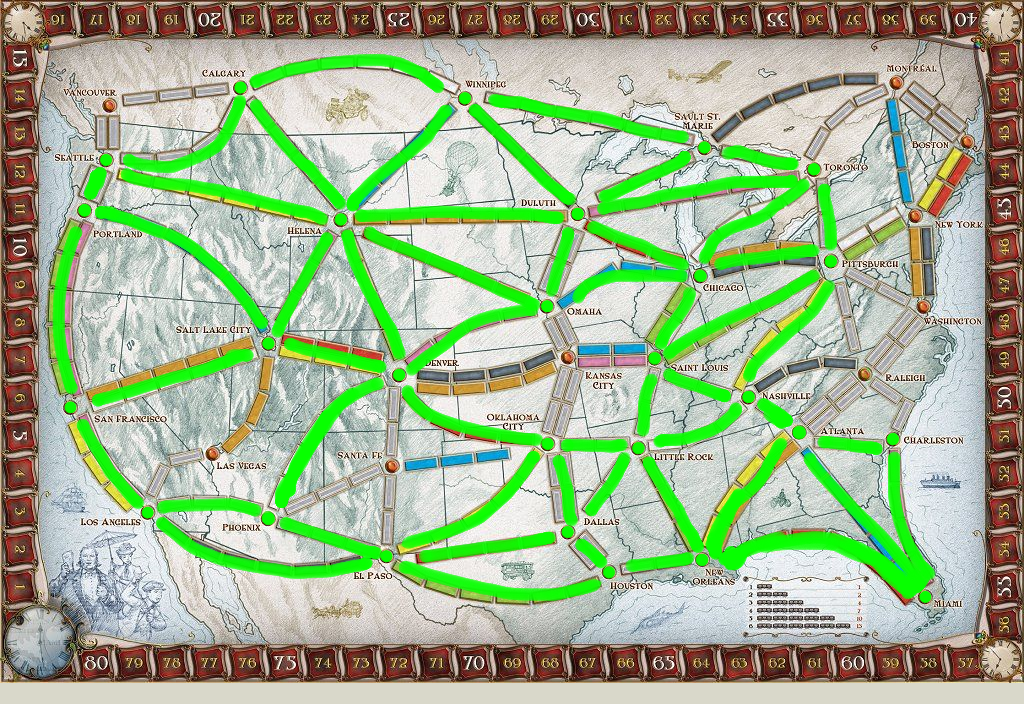

In [8]:
from IPython.display import Image
Image(filename='TicketToRide.png')